In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from scikitplot.estimators import plot_learning_curve

import matplotlib.pyplot as plt
import datetime as dt

import shap

import warnings
warnings.filterwarnings('ignore')

filename = 'konkurs_3_5_20210425_0700'

In [37]:
print("#### import data")
train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5') 
df_all = pd.concat([train, test], axis=0)
print("train & test: ", train.shape, test.shape)

#### import data
train & test:  (45694, 35) (22667, 35)


In [38]:
def extract_geoblock(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"geo_block_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

def extract_breadcrumbs(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"breadcrumbs{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

#SPLIT DATA
def split_breadcrumbs(row, string):
    result = "-1"
    len_ = len(row)
    for x in range(len_):
        if string in row[x]:
            result = row[x]

    return result


def split_date(row, idx):
    result = "-1"
    len_ = len(row)
    if len_ > idx:
        result = row[idx]

    return result

def split_date_DMY(row, idx):
    result = "-1"
    
    date_ = row.split(' ')
    len_ = len(date_)
    if len_ > idx:
        result = date_[idx]
        if "сегодня" in result:
            result = "+2"
        if "вчера" in result:
            result = "+1"
        if ":" in result:
            result = "-1"
            
    return result

# dictionaries
Security_dict = {
"access_control":[
    "access control system","access system","access control","Access system","video surveillance and access control system",
    "Concierge allow you not to worry about the safety of your stay. Video surveillance and access control systems make it impossible to enter the territory of unwanted guests",
    "Access control and security systems","electronic access control","Checkpoint","checkpoint.","control of access to the territory",
    "The whole territory of the residential complex is equipped with access control system","centralized access control system"
],
"alarm":[
    "burglar alarm","Alarm system","alarm system","security alarm of all premises with life support systems of the building",
    "warning system and evacuation management","security alarm","alarms"
],
"concierge":[
    "Concierge","Concierge service 24/7","24-hour Concierge service","Provided to help",
    "Concierge allow you not to worry about the safety of your stay. Video surveillance and access control systems make it impossible to enter the territory of unwanted guests",
    "Concierge service","Concierge. Doorphone.","Concierge and security facilities","24-hour security and Concierge service","a place for the Concierge",
    "there is a room for the Concierge","enclosed courtyard"
],
"fenced":[
    "closed area","enced area","barrier","Fenced","Fenced guarded territory","Fenced perimeter","fenced protected area","closed territory","the area is fenced",
    "fenced","Fenced area","The whole area is fenced and guarded around the clock.","landscaped and fenced area","fenced area with security","fenced guarded area",
    "ogorojennaja territory","Fenced and protected area","Perimeter fencing","The territory of the complex is fenced and guarded","Protected fenced area"
],
"fire_system":[
    "Fire system","automatic fire extinguishing systems","automatic fire alarm"
],
"high_quality":[
    "high-quality and safe playgrounds.","high-tech 24-hour security"
],
"intercom":[
    "intercom","video intercom","video intercoms","Concierge. Doorphone.","IP-intercom"
],
"landscaping":[
    "the area with landscaping and the use of small architectural forms","landscaping	landscaped and fenced area"
],
"monitoring":[
    "video surveillance","video Surveillance","video monitoring","the Presence of CCTV","video surveillance and access control system","CCTV",
    "Concierge allow you not to worry about the safety of your stay. Video surveillance and access control systems make it impossible to enter the territory of unwanted guests",
    "video surveillance of the perimeter of the building","Video surveillance","CAT t",
    "The territory of the complex is equipped with round-the-clock video surveillance of the entire perimeter and security.","24-hour video surveillance",
    "round-the-clock video surveillance","Video perimeter monitoring","the Presence of video surveillance","video surveillance system","video surveillance systems",
    "organized around the clock video surveillance.","video monitoring system","round-the-clock video surveillance. Guarded By Chop.",
    "The presence of video surveillance","fenced territory with CCTV cameras","video surveillance on the perimeter"
],
"parking":[
    "Secure Parking","entrance and underground Parking.","landscaped courtyard with children's Playground and guest Parking."
],
"playgrounds":[
    "high-quality and safe playgrounds.","landscaped courtyard with children's Playground and guest Parking."
],
"security":[
    "provided","Yes","round the clock security","well guarded by security cameras around the perimeter","24-hour security","round the clock security.",
    "protected area","checkpoint","round the Clock security","Protected area","security","Protected Chop","private protected area","secure Parking",
    "multilevel round-the-clock armed security","professional round-the-clock security","Round-the-clock security system","24-hour security of the complex",
    "multi-level security system","security alarm of all premises with life support systems of the building","guarded area",
    "The whole area is fenced and guarded around the clock.","protected","secure area","Private protected area","Round the clock protected area",
    "The territory of the complex is equipped with round-the-clock video surveillance of the entire perimeter and security.","fenced area with security",
    "Access control and security systems","perimeter security","Professional round-the-clock security","Multilevel security system","Guarded by Chop",
    "fenced guarded area","Security system","security post","armed guards","24-hour guarded territory","professional security service",
    "Concierge and security facilities","Fenced and protected area","24-hour security and Concierge service","security alarm",
    "round-the-clock video surveillance. Guarded By Chop.","The territory of the complex is fenced and guarded","Round the clock security",
    "Protected fenced area","Protected","high-tech 24-hour security","Integrated security system"
]
}

month = pd.DataFrame({ "date_0_1" : ["января","февраля","марта","апреля","мая",
                                     "июня","июля","августа","сентября",
                                     "октября","ноября","декабря" ],
                       "date_month_cat" : ['01','02','03','04','05','06','07',
                                          '08','09','10','11','12']
                    })

metro_stations = pd.DataFrame({
"breadcrumbs_MCK":[
         "МЦК Крымская","МЦК Кутузовская","МЦК Шелепиха","МЦК Лужники","МЦК Коптево","МЦК Хорошёво",
         "МЦК ЗИЛ","МЦК Шоссе Энтузиастов","МЦК Нижегородская","МЦК Угрешская","МЦК Владыкино",
         "МЦК Лихоборы","МЦК Ботанический сад","МЦК Балтийская","МЦК Зорге","МЦК Ростокино",
         "МЦК Локомотив","МЦК Деловой центр","МЦК Андроновка","МЦК Новохохловская","МЦК Соколиная Гора",
         "МЦК Стрешнево","МЦК Площадь Гагарина","МЦК Окружная","МЦК Панфиловская","МЦК Верхние Котлы",
         "МЦК Дубровка","МЦК Бульвар Рокоссовского","МЦК Автозаводская","МЦК Белокаменная","МЦК Измайлово"
        ],
 "N_cat"    :[
     55.689996,55.739723,55.759055,55.720938,55.8339615,55.777063,
     55.697998,55.758903,55.732153,55.7172056,55.8460453,
     55.8461625,55.8456095,55.8245848,55.7889196,55.84286,
     55.8032813,55.7477698,55.7459043,55.7240081,55.7715129,
     55.813731,55.706997,55.8488708,55.7990171,55.690124,
     55.7126485,55.817222,55.706525,55.8247339,55.7884887
 ],
 "E_cat"    :[
     37.6030233,37.5322383,37.5204276,37.5578673,37.5095698,37.5052353,
     37.6455663,37.7438224,37.7259292,37.694126,37.5871309,
     37.57181,37.6375244,37.4928893,37.5017478,37.6630943,
     37.7431398,37.5298063,37.7356328,37.7143756,37.7429271,
     37.4848013,37.5841133,37.5699377,37.4967285,37.6165353,
     37.675508,37.7347544,37.6612083,37.6935242,37.7423137     
 ],
 "dist_to_red_square_cat" :[
     0.065474699499651200,0.087583479903288500,0.098447525258996600,0.069047169411717700,0.135566934589415000,0.115894398869703000,
     0.061707928222957200,0.125214708292993000,0.109324042363335000,0.083710909065539700,0.097730971999673100,
     0.103806377065432000,0.093949381526707200,0.144492862318421000,0.122201190447971000,0.099715880839365500,
     0.133985005816959000,0.089103788900196600,0.117161550121057000,0.100115116606079000,0.125496038555646000,
     0.146816601480113000,0.058016705643890100,0.107069396626726000,0.130186815633074000,0.063474566769454200,
     0.069989344485068300,0.132349246777230000,0.063383649850489500,0.103252166733923000,0.128432603636457000
 ],
 "dist_to_airport_Szere_cat":[
     0.296360388194812000,0.230551909339703000,0.224014637566945000,0.252853413120291000,0.247605377828677000,0.216000276998391000,
     0.338948568412645000,0.442235366506402000,0.421173209378202000,0.388272034151328000,0.319959674379398000,
     0.306677693421351000,0.364755362770447000,0.228569990859038000,0.217807025951987000,0.387018390667653000,
     0.450421186246167000,0.229989094738207000,0.432330698167272000,0.408956539604296000,0.443435782471661000,
     0.215726846441931000,0.277845867499556000,0.306437585575431000,0.218094277412802000,0.309871258872106000,
     0.369412974341512000,0.446010492707349000,0.354833843221558000,0.408977175985263000,0.446191310536960000

 ],
 "dist_to_airport_Domod_cat":[
     0.280352599357255000,0.341505576431436000,0.363322450119583000,0.317243187838553000,0.438396276839995000,0.384985918522181000,
     0.288630376759217000,0.369170636618699000,0.338118239531228000,0.315191688822688000,0.437155363452810000,
     0.438770252015069000,0.435568753432807000,0.434019909475090000,0.397341648226938000,0.434472516266529000,
     0.411133993349334000,0.349908952325272000,0.354217392443069000,0.326934821351179000,0.380815829261124000,
     0.426212235233535000,0.299137479860966000,0.441678723023929000,0.408489652356089000,0.279876472868956000,
     0.306987858059841000,0.422168110091536000,0.298762491551681000,0.420502840941041000,0.396767924663372000

 ],
 "dist_to_airport_Wnuko_cat":[
     0.296363998094992000,0.230497277313749000,0.223934803143412000,0.252824010555265000,0.247450606297197000,0.215894638429606000,
     0.338945492302891000,0.442195833660878000,0.421148940052902000,0.388256068177328000,0.319830009818745000,
     0.306542226606790000,0.364642174455572000,0.228413390746622000,0.217687396939553000,0.386913757493900000,
     0.450355517985038000,0.229924775435290000,0.432298423060469000,0.408936927525318000,0.443388603635436000,
     0.215574576576760000,0.277832934882547000,0.306299593354689000,0.217962145505179000,0.309874668582722000,
     0.369399474317778000,0.445935626128301000,0.354824426806060000,0.408890361344124000,0.446134052143902000
 
        
 ]
})

#red_square = {"N_cat":[55.7535609],"E_cat":[37.6187217]}


In [39]:
print("############ start extract") 
print("#### extract columns with :")  
factorize_feats = [f for f in df_all.columns if ":" in f]
for feat in factorize_feats:
    df_all["{}_cat".format(feat)] = df_all[feat].factorize()[0]

print("#### extract geo_block")      
df_geo_block = df_all["geo_block"].map(extract_geoblock).apply(pd.Series)
df_all = pd.concat([df_all, df_geo_block], axis=1)

feats_geo_block = [ x for x in df_geo_block.columns]
for f in feats_geo_block:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]
    
print("#### extract breadcrumbs 1")      
df_breadcrumbs = df_all["breadcrumbs"].map(extract_breadcrumbs).apply(pd.Series)
df_all = pd.concat([df_all, df_breadcrumbs], axis=1)

feats_breadcrumbs = [ x for x in df_breadcrumbs.columns]
for f in feats_breadcrumbs:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]

print("#### extract Security")
for idx in Security_dict:
    df_all[idx+"_cat"] = df_all["Security:"].apply(lambda x: 1 if set(str(x).replace(", ",",").split(",")) & set(Security_dict[idx]) else 0)

print("#### extract breadcrumbs 2")
df_all["breadcrumbs_MCK"] = df_all.apply(lambda df: split_breadcrumbs(df["breadcrumbs"],"МЦК "), axis=1)
#df_all["breadcrumbs_STR"] = df_all.apply(lambda df: split_breadcrumbs(df["breadcrumbs"],"ул. "), axis=1)
df_all = df_all.merge(metro_stations, how="left", on=["breadcrumbs_MCK"])

df_all["N_cat"] = df_all["N_cat"].fillna(-1)
df_all["E_cat"] = df_all["E_cat"].fillna(-1)
df_all["dist_to_red_square_cat"] = df_all["dist_to_red_square_cat"].fillna(-1)
df_all["dist_to_airport_Szere_cat"] = df_all["dist_to_airport_Szere_cat"].fillna(-1)
df_all["dist_to_airport_Domod_cat"] = df_all["dist_to_airport_Domod_cat"].fillna(-1)
df_all["dist_to_airport_Wnuko_cat"] = df_all["dist_to_airport_Wnuko_cat"].fillna(-1)

df_all['breadcrumbs_MCK_cat'] = pd.factorize(df_all['breadcrumbs_MCK'])[0]

df_all["breadcrumbs_count_cat"] = df_all["breadcrumbs"].apply(lambda x: len(str(x).split(",")))

print("#### extract date")
df_all["date_0"] = df_all.apply(lambda df: split_date(df["date"],0), axis=1)
df_all["date_1"] = df_all.apply(lambda df: split_date(df["date"],1), axis=1)
df_all["date_2"] = df_all.apply(lambda df: split_date(df["date"],2), axis=1)

df_all["date_day_no"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],0), axis=1)
df_all["date_0_1"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],1), axis=1)
df_all["date_year_cat"] = df_all.apply(lambda df: split_date_DMY(df["date_0"],2), axis=1)

df_all = df_all.merge(month, how="left", on=["date_0_1"])

df_all["date_month_cat"] = df_all["date_month_cat"].fillna(-10)
df_all["date_1_cat"] = pd.factorize(df_all['date_1'])[0]

df_all = df_all.astype({
                        "date_month_cat": int, 
                        "date_year_cat": int}
                       )

max_year = df_all["date_year_cat"].max()

#find data in last year
df_in_last_year = df_all["date_year_cat"] == -1
df_all.loc[df_in_last_year,"date_year_cat"] = max_year + 1


max_month = df_all["date_month_cat"].where(df_in_last_year).max()
df_in_last_month = df_all["date_month_cat"] == -10
df_all.loc[df_in_last_month,"date_month_cat"] = max_month

max_new_year = df_all["date_year_cat"].max()
df_in_new_year = df_all["date_year_cat"] == max_new_year
max_new_month = df_all["date_month_cat"][df_in_new_year].max()#.astype(int)
df_in_new_year_month = df_all["date_month_cat"] == max_new_month
max_new_day = int(df_all["date_day_no"][df_in_new_year & df_in_new_year_month].max())

df_all["date_day_"] = df_all["date_day_no"].apply(lambda x : int(x) + max_new_day  if "+" in x else x)

df_all = df_all.astype({
                        "date_month_cat": int, 
                        "date_year_cat": int, 
                        "date_day_": int}
                       )

df_all["year"] = df_all["date_year_cat"]
df_all["month"] = df_all["date_month_cat"]
df_all["day"] = df_all["date_day_"]
df_all["date_date"] = pd.to_datetime(df_all[["year","month","day"]])
df_all["date_week_cat"] = df_all["date_date"].dt.week
df_all["date_dayodweek_cat"] = df_all["date_date"].dt.dayofweek

print("#### extract owner")
df_all["owner_cat"] = df_all["owner"].apply(lambda x: 1 if len(str(x)) > 2 else 0)

print("############ end extract") 

############ start extract
#### extract columns with :
#### extract geo_block
#### extract breadcrumbs 1
#### extract Security
#### extract breadcrumbs 2
#### extract date
#### extract owner
############ end extract


In [16]:
#df_all[['date_year_cat']].info()
#df_all[['date_month_cat']].info()
#df_all[['date_day_cat']].info()

#pd.to_datetime(df_all[["date_year_cat","date_month_cat","date_day_cat"]])
#import datetime
#df_all.apply(lambda x: datetime.date(df_all['date_year_cat'], df_all['date_month_cat'], df_all['date_day_cat']),axis=1)
#print([datetime(y,m,d) for y,m,d in zip(df_all["date_year_cat"],df_all["date_month_cat"],df_all["date_day_cat"])])
#pd.to_datetime((int(df_all['date_year_cat'])*10000+int(df_all['date_month_cat'])*100+int(df_all['date_day_cat'])).astype('int'), format='%Y%m%d')
#max_new_day

In [17]:
#all_breadcrumbs = set()
#
#def extract_breadcrumbs(breadcrumbs):
#    if 'nan' == str(breadcrumbs): return
#    
#    for value in str(breadcrumbs).replace('[','').replace(']','').replace("'","").split(','):
#        value = value.lower().strip()
#        for value2 in value.split('.'):
#            if '' == value2: continue
#            
#            value2 = value2.lower().strip()
#            
#            all_breadcrumbs.add(value2)
#    
#_ = df_all['breadcrumbs'].map(extract_breadcrumbs)
#
#set(all_breadcrumbs)

In [5]:
feats = [x for x in df_all.columns if "_cat" in x]

#feats_tmp = df_all[ False ==  df_all["price"].isnull() ].select_dtypes(include= [np.int8,np.int16,np.int64]).columns.values
feats_tmp = df_all[ False ==  df_all["price"].isnull() ].select_dtypes(include= [np.int8,np.int16,np.int64]).columns.values
#df_all[[x for x in df_all.columns if "_cat" in x]] = df_all[[x for x in df_all.columns if "_cat" in x]].astype(np.int)
df_all[feats_tmp] = df_all[feats_tmp].astype(np.int)
print("feats: ", len(feats))
print(feats)


feats:  66
['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'geo_block_0_cat', 'geo_block_1_cat', 'geo_block_2_cat', 'geo_block_3_cat', 'geo_block_4_cat', 'geo_block_5_cat', 'breadcrumbs0_cat', 'breadcrumbs1_cat', 'breadcrumbs2_cat', 'breadcrumbs3_cat', 'access_control_cat', 'alarm_cat', 'concierge_cat', 'fenced_cat', 'fire_system_cat', 'high_quality_cat', 'intercom_cat', 'landscaping_cat', 'monitoring_cat', 'par

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68361 entries, 0 to 68360
Columns: 123 entries, breadcrumbs to owner_cat
dtypes: datetime64[ns](1), float64(8), int32(64), object(50)
memory usage: 48.0+ MB


In [19]:
print("############ start prepering ProfileReport")
if 1 == 0:
    import pandas_profiling

    feats_to_report = [x for x in df_all.columns if "_cat" in x]
    feats_to_report.append("price")
    print("feats: ", len(feats_to_report))
    print((feats_to_report))

    profile_train = pandas_profiling.ProfileReport(df_all[feats_to_report])
    profile_train.to_file(output_file="{}.html".format(filename))
print("############ end prepering ProfileReport")

############ start prepering ProfileReport
feats:  67
['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 'geo_block_0_cat', 'geo_block_1_cat', 'geo_block_2_cat', 'geo_block_3_cat', 'geo_block_4_cat', 'geo_block_5_cat', 'breadcrumbs0_cat', 'breadcrumbs1_cat', 'breadcrumbs2_cat', 'breadcrumbs3_cat', 'access_control_cat', 'alarm_cat', 'concierge_cat', 'fenced_cat', 'fire_system_cat', 'high_quality_cat', 'intercom_cat'


############ end prepering ProfileReport


In [ ]:
['Security:_cat', 'Building type:_cat', 'Object type:_cat', 'Ad type:_cat', 'Commission agent:_cat', 
 'Construction phase:_cat', 'Housing class:_cat', 'Elevator:_cat', 'Bathroom type:_cat', 'Balcony type:_cat', 
 'Mortgage possible:_cat', 'The view from the window:_cat', 'Garbage chute:_cat', 'Repair:_cat', 'Fridge:_cat', 
 'Phone:_cat', 'Furniture:_cat', 'Free layout:_cat', 'It is possible to bargain:_cat', 'Floor covering:_cat', 
 'Room type:_cat', 'Internet:_cat', 'Kitchen furniture:_cat', 'TV:_cat', 'Washing machine:_cat', 'Foundation type:_cat', 
 'Overlap type:_cat', 'Type of the building:_cat', 'Playground:_cat', 'Class:_cat', 
 'geo_block_0_cat', 'geo_block_1_cat', 'geo_block_2_cat', 'geo_block_3_cat', 'geo_block_4_cat', 'geo_block_5_cat', 
 'breadcrumbs0_cat', 'breadcrumbs1_cat', 'breadcrumbs2_cat', 'breadcrumbs3_cat', 
 'access_control_cat', 'alarm_cat', 'concierge_cat', 'fenced_cat', 'fire_system_cat', 'high_quality_cat', 'intercom_cat', 'landscaping_cat', 
 'monitoring_cat', 'parking_cat', 'playgrounds_cat', 'security_cat', 
 'N_cat', 'E_cat', 
 'dist_to_red_square_cat', 'dist_to_airport_Szere_cat', 'dist_to_airport_Domod_cat', 'dist_to_airport_Wnuko_cat', 
 'breadcrumbs_MCK_cat', 'breadcrumbs_count_cat', 'date_year_cat', 'date_month_cat', 'date_1_cat', 'date_week_cat', 'date_dayodweek_cat', 'owner_cat']

In [18]:
feats = [
    'Housing class:_cat',
    'Building type:_cat',
    'geo_block_0_cat',
    'Construction phase:_cat',
    'dist_to_airport_Szere_cat',
    'The view from the window:_cat',
    'N_cat',
    'dist_to_red_square_cat',
    'Bathroom type:_cat',
    'geo_block_1_cat',
    'Object type:_cat',
    'E_cat',
    'Ad type:_cat',
    'breadcrumbs_MCK_cat',
    'date_1_cat',
    'date_week_cat',
    'breadcrumbs1_cat',
    'Security:_cat',
    'date_dayodweek_cat'
]


In [56]:
print("#### split to df_train, df_test")
df_train, df_test = df_all[ False ==  df_all["price"].isnull() ], df_all[ df_all["price"].isnull() ]

models = [
          [RandomForestRegressor(n_estimators=400, max_depth = 50, max_features='sqrt', min_samples_split=8, random_state=40, bootstrap = True,oob_score = True),
           xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, max_depth=15, random_state=0),
           #lgb.LGBMRegressor(n_estimators=100, random_state=0, max_depth=15),
           ctb.CatBoostRegressor(n_estimators=500, learning_rate=0.03, depth=12, random_state=40, verbose=False),
           HistGradientBoostingRegressor(learning_rate=0.3, max_depth=15, random_state=20)],
          [0.2, 
           0.2, 
           #0.2, 
           0.2, 
           0.4]
]

#models = [
#          [RandomForestRegressor(n_estimators=500, max_depth = 20, max_features='sqrt')],
#          [1]
#]


#### split to df_train, df_test


############ start train/test
#### split to X_train, X_test, y_train, y_test
model -> <class 'sklearn.ensemble._forest.RandomForestRegressor'>
CPU times: user 14.8 s, sys: 306 ms, total: 15.1 s
Wall time: 15.2 s
RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=8,
                      n_estimators=400, oob_score=True, random_state=40)
model -> <class 'xgboost.sklearn.XGBRegressor'>
CPU times: user 27.2 s, sys: 173 ms, total: 27.4 s
Wall time: 27.5 s
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='

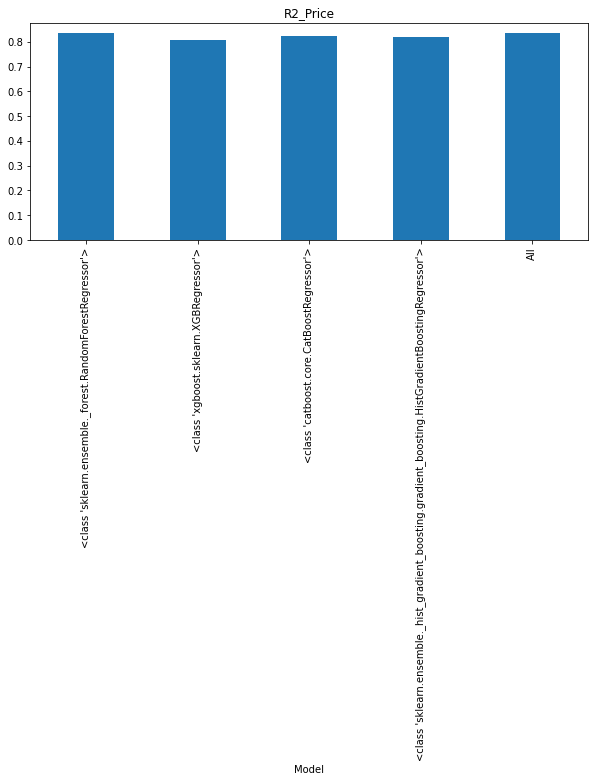

                                                    R2_Price  mae_Price
Model                                                                  
<class 'sklearn.ensemble._forest.RandomForestRe...  0.833988   0.196467
<class 'xgboost.sklearn.XGBRegressor'>              0.805722   0.202686
<class 'catboost.core.CatBoostRegressor'>           0.822927   0.204577
<class 'sklearn.ensemble._hist_gradient_boostin...  0.818102   0.209598
All                                                 0.835500   0.196079
############ end train/test


In [57]:
print("############ start train/test") 

print("#### split to X_train, X_test, y_train, y_test")
X_train, X_test, y_train, y_test = train_test_split(df_train[feats],
                                                    df_train[['price']],
                                                    test_size=0.3)
TestModels = pd.DataFrame()
tmp = {}
y_pred_log_tmp = np.zeros(len(y_test))
run_plot = 1

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

for i in range(len(models[0])):
    model = models[0][i]
    weight = models[1][i]

    # get model name
    m = str(model)
    print('model ->', type(model))#m[:m.index('(')])
    tmp['Model'] = type(model)#m[:m.index('(')]
    # fit model on training dataset
    %time model.fit(X_train, y_train_log)
    # predict prices for test dataset and calculate r^2
    print((model))
    y_pred_log = model.predict(X_test)
 

    y_pred_log_tmp = y_pred_log_tmp + (y_pred_log * weight)
    
    tmp['R2_Price'] = r2_score(y_test_log, y_pred_log)
    tmp['mae_Price'] = mean_absolute_error(y_test_log, y_pred_log)
    # write obtained data
    TestModels = TestModels.append([tmp])
    
    #if run_plot == 1:
        #explainer = shap.Explainer(model)
        #shap_values = explainer(X_test)
        #plot_learning_curve(model, X_train, y_train_log, cv=3, random_state=0, shuffle=True)
        #plt.show()

    
tmp['Model'] = 'All'
tmp['R2_Price'] = r2_score(y_test_log, y_pred_log_tmp)
tmp['mae_Price'] = mean_absolute_error(y_test_log, y_pred_log_tmp)
TestModels = TestModels.append([tmp])

TestModels.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
TestModels.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()
print(TestModels)
print("############ end train/test") 

In [58]:
print("############ start train/save") 
save_file = 1

if save_file == 0:
    print("#### split to X_train, X_test, y_train, y_test")
    run_plot = 1
    y_test_log = np.log(y_test)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train[feats],
                                                        df_train[['price']],
                                                        test_size=0.33)
else:
    print("#### split to X_train, X_test, y_train, y_pred")
    run_plot = 0
    
    X_train, X_test = df_train[feats].values, df_test[feats].values
    y_train = df_train["price"].values
    
TestModels = pd.DataFrame()
tmp = {}
y_pred_log_tmp = np.zeros(len(df_test["price"]))

y_train_log = np.log(y_train)


for i in range(len(models[0])):
    model = models[0][i]
    weight = models[1][i]

    # get model name
    m = str(model)
    print('model ->', type(model))#m[:m.index('(')])
    tmp['Model'] = type(model)#m[:m.index('(')]
    # fit model on training dataset
    %time model.fit(X_train, y_train_log)
    # predict prices for test dataset and calculate r^2
    y_pred_log = model.predict(X_test)
    
    if len(models[0]) > 1:
        y_pred_log_tmp = y_pred_log_tmp + (y_pred_log * weight)
    else:
        y_pred_log_tmp = y_pred_log
    
print("### save file "+'{}.csv'.format(filename))

test['price'] = np.exp(y_pred_log_tmp)
test[ ['id', 'price'] ].to_csv('{}_2359.csv'.format(filename), index=False)    
    
print("############ end train/save") 

############ start train/save
#### split to X_train, X_test, y_train, y_pred
model -> <class 'sklearn.ensemble._forest.RandomForestRegressor'>
CPU times: user 22 s, sys: 408 ms, total: 22.4 s
Wall time: 22.5 s
model -> <class 'xgboost.sklearn.XGBRegressor'>
CPU times: user 37.8 s, sys: 185 ms, total: 37.9 s
Wall time: 38.1 s
model -> <class 'catboost.core.CatBoostRegressor'>
CPU times: user 2min 27s, sys: 1min 28s, total: 3min 55s
Wall time: 54.4 s
model -> <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>
CPU times: user 2.4 s, sys: 651 ms, total: 3.05 s
Wall time: 3.07 s
### save file konkurs_3_5_20210425_0700.csv
############ end train/save


In [10]:
#df_all.to_csv('konkurs_3_5_prepereddata_20210425.csv'.format(filename), index=False)

############ start train/test
#### split to X_train, X_test, y_train, y_test
CPU times: user 1min 20s, sys: 469 ms, total: 1min 21s
Wall time: 1min 21s
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


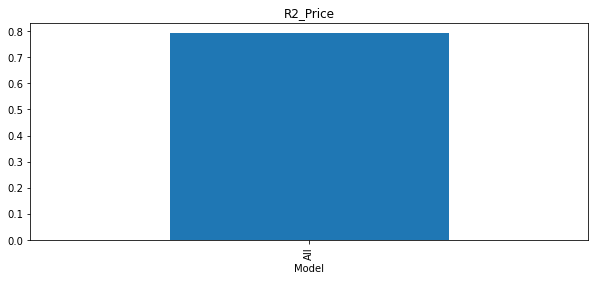

       R2_Price  mae_Price
Model                     
All    0.792157   0.208962
############ end train/test


In [40]:
print("############ start train/test") 
TestModels = pd.DataFrame()
print("#### split to X_train, X_test, y_train, y_test")
X_train, X_test, y_train, y_test = train_test_split(df_train[feats],
                                                    df_train[['price']],
                                                    test_size=0.4)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=15, random_state=0, n_jobs=-1)
#model = RandomForestRegressor(n_estimators=2000, max_depth = 18, max_features='sqrt', random_state=20, bootstrap = True,oob_score = True, n_jobs=-1)
# fit model on training dataset
%time model.fit(X_train, y_train_log)
# predict prices for test dataset and calculate r^2
print((model))
y_pred_log = model.predict(X_test)
 

tmp['R2_Price'] = r2_score(y_test_log, y_pred_log)
tmp['mae_Price'] = mean_absolute_error(y_test_log, y_pred_log)
TestModels = TestModels.append([tmp])

TestModels.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
TestModels.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()
print(TestModels)
print("############ end train/test") 

In [41]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

AttributeError: module 'shap' has no attribute 'Explainer'

In [35]:
shap.plots.bar(shap_values,max_display = 30)

NameError: name 'shap_values' is not defined

In [ ]:
import warnings
from sklearn.metrics import mean_squared_error, max_error, r2_score
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

warnings.filterwarnings('ignore')

df_train, df_test = df_all[ False ==  df_all["price"].isnull() ], df_all[ df_all["price"].isnull() ]

X_train, X_test, y_train, y_test = train_test_split(df_train[feats],df_train[['price']],test_size=0.33)

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    print('loss',score)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 40, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 1000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

In [52]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator = grid.best_estimator_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 14.0min finished


In [53]:
best_estimator

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_split=8,
                      n_estimators=400)

In [ ]:
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor()
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator = grid.best_estimator_